In [20]:
import numpy as np
import matplotlib.pyplot as plt
from quantum_tunneling.workflows import run_bound_states, run_tdse, run_field_scan
from quantum_tunneling.viz import create_wavefunction_animation
from quantum_tunneling.fields import apply_field
import matplotlib.animation as animation

In [21]:
potentials = {
    "cusp": {"kind": "cusp", "params": {"V0": 10.0, "alpha": 0.5}},
    "exp_well": {"kind": "exp_well", "params": {"V0": 5.0, "a": 1.0}},
    "soft_barrier": {"kind": "soft_barrier", "params": {"V0": 5.0}},
    "rough": {"kind": "rough", "params": {"V0": 1.0, "k0": 0.6, "levels": 4, "decay": 0.6}},
}
pot_key = "cusp"
state_index = 1
L=30.0
cfg = {
    "potential": potentials[pot_key],
    "grid": {"L": L, "N": 1200},
    "solver": {"k": 6, "hbar": 1.0, "m": 1.0},
    "tdse": {
        "dt": 0.002,
        "duration": 48.0,
        "record_interval": 50,
        "hbar": 1.0,
        "m": 1.0,
        "F": 2,
        "cap": {"x_start": L-4, "x_end": L-0.5, "strength": 30.0, "power": 2},
    },
}
cfg

{'potential': {'kind': 'cusp', 'params': {'V0': 10.0, 'alpha': 0.5}},
 'grid': {'L': 30.0, 'N': 1200},
 'solver': {'k': 6, 'hbar': 1.0, 'm': 1.0},
 'tdse': {'dt': 0.002,
  'duration': 48.0,
  'record_interval': 50,
  'hbar': 1.0,
  'm': 1.0,
  'F': 2,
  'cap': {'x_start': 26.0, 'x_end': 29.5, 'strength': 30.0, 'power': 2}}}

In [22]:
res = run_bound_states(cfg)
td = run_tdse(cfg, res, state_index=state_index)
frames = td['frames']
survival = td['survival']
total = td['total']
j1= td['j1']
j2= td['j2']
x1= td['x1']
x2= td['x2']
times = [f['t'] for f in frames]
E = res['E'][state_index]


In [23]:
print(f"Selected state energy: E = {E:.4f}")
print(f"Flux at x1={x1:.2f}: j1 = {j1[-1]:.31f}")
print(f"Flux at x2={x2:.2f}: j2 = {j2[-1]:.31f}")

Selected state energy: E = 10.0672
Flux at x1=1.95: j1 = 0.0383897651225156219534362378454
Flux at x2=12.98: j2 = 0.0000354456108230446885086137310


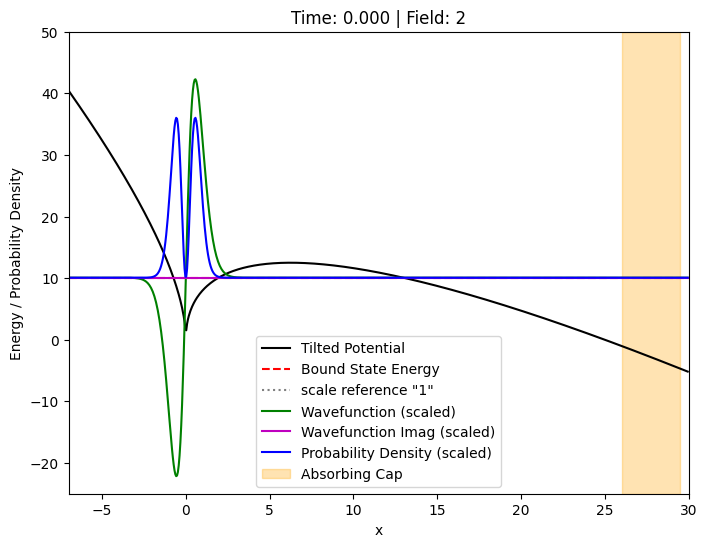

In [24]:
# Create animation
x = res['x']
Vx = res['Vx']
Vtilt = apply_field(Vx, x, cfg['tdse']['F'])
fig, ax = plt.subplots(figsize=(8, 6))
scale = 40
def update(frame):
    ax.clear()
    ax.set_title(f'Time: {frame["t"]:.3f} | Field: {cfg["tdse"]["F"]}')
    ax.plot(x, Vtilt, 'k-', label='Tilted Potential')
    ax.axhline(E, color='r', linestyle='--', label='Bound State Energy')
    ax.axhline(E+scale, color='gray', linestyle=':', label='scale reference "1"')
    
    psi = frame['psi']
    prob_density = np.abs(psi)**2
    psi_real = np.real(psi)
    ax.plot(x,E+ psi_real * scale, 'g-', label='Wavefunction (scaled)')
    psi_imag = np.imag(psi)
    ax.plot(x, E + psi_imag * scale, 'm-', label='Wavefunction Imag (scaled)')
    ax.plot(x, E + prob_density * scale, 'b-', label='Probability Density (scaled)')
    
    # draw cap region
    cap = cfg['tdse']['cap']
    ax.axvspan(cap['x_start'], cap['x_end'], color='orange', alpha=0.3, label='Absorbing Cap')
    ax.set_ylim(-25, 50)
    ax.set_xlim(-7, cfg["grid"]["L"])
    ax.set_xlabel('x')
    ax.set_ylabel('Energy / Probability Density')
    ax.legend()
ani = animation.FuncAnimation(fig, update, frames=frames, repeat=False)
ani.save(f'time_evolution_V0_{potentials[pot_key]["params"]["V0"]}_F_{cfg["tdse"]["F"]}_state_{state_index}.gif', writer='pillow', fps=30)


Estimated escape rate from TDSE simulation: -5.648357e-04


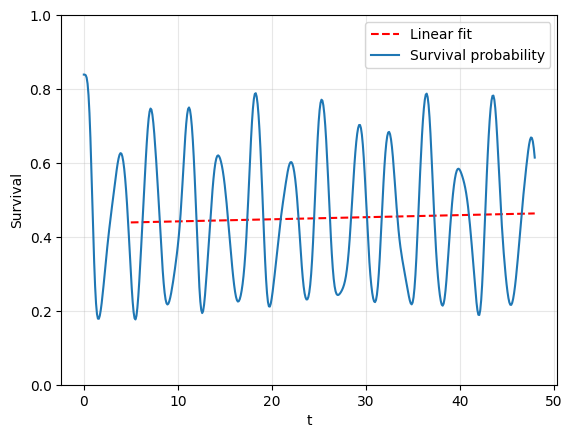

Estimated transmission coefficient T_tdse = -9.194185e-03 from flux ratio j2/j1


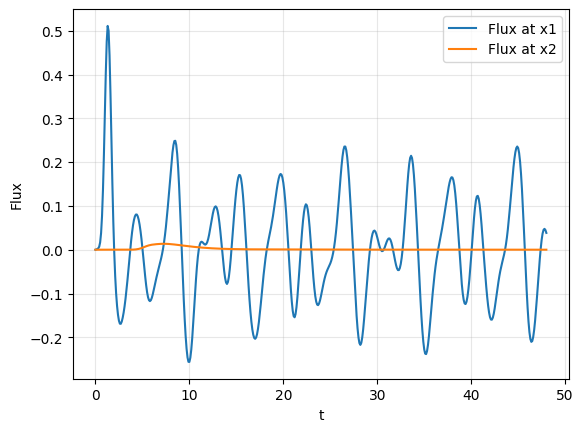

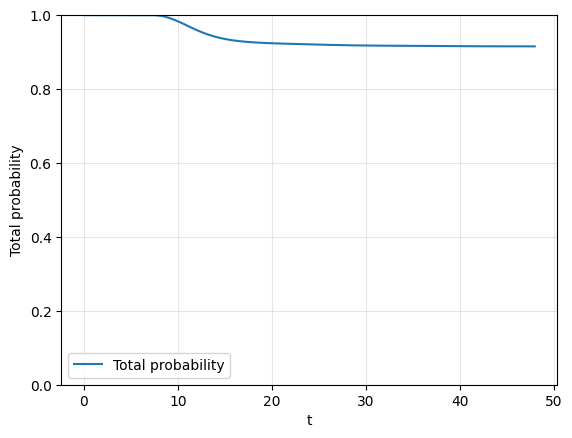

481
Estimated escape rate from total probability decay: 1.534161e-04


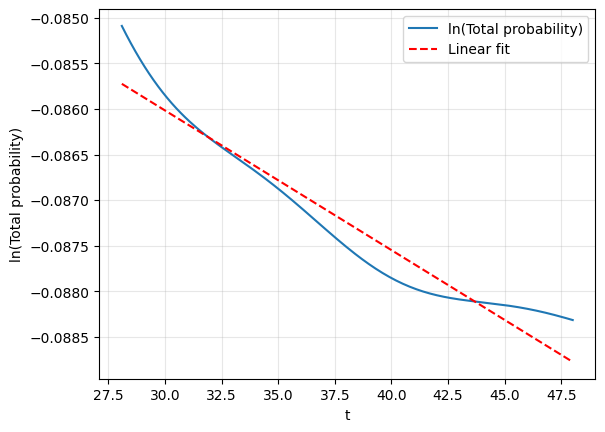

In [35]:

# Use a linear function to fit the decay of the survival probability, which gives the escape rate
# Exclude the first 5 time units and fit the remaining data
import scipy.stats as stats
fit_start_time = 5.0
fit_indices = [i for i, t in enumerate(times) if t >= fit_start_time]
fit_times = np.array([times[i] for i in fit_indices])
fit_survival = np.array([survival[i] for i in fit_indices])
slope, intercept, r_value, p_value, std_err = stats.linregress(fit_times, fit_survival)
plt.plot(fit_times, intercept + slope * fit_times, 'r--', label='Linear fit')
escape_rate_tdse = -slope
print(f"Estimated escape rate from TDSE simulation: {escape_rate_tdse:.6e}")
plt.plot(times, survival, label='Survival probability')
plt.xlabel('t')
plt.ylabel('Survival')
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 画出flux稳定后，j2_avg / j1_avg的比值，用来估计透射率
# 取最后100个点的平均值
j1_avg = np.mean(j1[-100:])
j2_avg = np.mean(j2[-100:])
T_tdse = j2_avg / j1_avg
print(f"Estimated transmission coefficient T_tdse = {T_tdse:.6e} from flux ratio j2/j1")
plt.plot(times, j1, label='Flux at x1')
plt.plot(times, j2, label='Flux at x2')
plt.xlabel('t')
plt.ylabel('Flux')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

plt.figure()
plt.plot(times, total, label='Total probability')
plt.xlabel('t')
plt.ylabel('Total probability')
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(len(total))
stable_last_frames_count = 200
last_frames = total[-stable_last_frames_count:]
# curve fitting ln(P_total) = a*t + b
ln_total = np.log(last_frames)
slope, intercept, r_value, p_value, std_err = stats.linregress(times[-stable_last_frames_count:], ln_total)
escape_rate_total = -slope
print(f"Estimated escape rate from total probability decay: {escape_rate_total:.6e}")
plt.figure()
plt.plot(times[-stable_last_frames_count:], np.log(total[-stable_last_frames_count:]), label='ln(Total probability)')
plt.plot(times[-stable_last_frames_count:], intercept + slope * np.array(times[-stable_last_frames_count:]), 'r--', label='Linear fit')
plt.xlabel('t')
plt.ylabel('ln(Total probability)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Notes
- Fit an exponential to `survival` vs time to estimate escape rate Γ.
- Increase `duration` or reduce `dt` for accuracy; ensure CAP starts outside the initial localization region.
- Swap `pot_key` and `F` to probe how exotic shapes tilt and affect escape.